# 300KW WAXS Detector Workflow

In [71]:
import os, glob, re
import numpy as np
import matplotlib.pyplot as plt
from smi_analysis import SMI_beamline


**Helper Functions**

In [72]:
def plot_2d_image(data, ax, extent=None, aspect=None):
    ax.imshow(data,
        vmin=np.percentile(data,1),
        vmax=np.percentile(data,99),
        cmap='inferno',
        extent=extent,
        aspect=aspect,
        origin='upper')

def get_wa(file_name):
    match_obj = re.search(pattern='_wa(\d+.\d+)', string=file_name.split('/')[-1])

    return float(match_obj.groups()[0])

## Collect data file names into a list

In [73]:
# Path to directory where data files are stored
data_path = os.getcwd()

# get all files within `data_path`
data_files = glob.glob(data_path + '/*')

# keep only file names
data_files = [f.split('/')[-1] for f in data_files]

# keep only .tif files
data_files = [f for f in data_files if f.endswith('.tif')]

# sort files by waxs detector rotation angle
data_files.sort(key=get_wa)

# make a list of all detector rotation angles
wa_list = [get_wa(f) for f in data_files]

print('Files Found: ', data_files)
print('WAXS Detector Angles: ', wa_list)


Files Found:  ['300kw_wa0.0.tif', '300kw_wa6.5.tif', '300kw_wa13.0.tif', '300kw_wa19.5.tif', '300kw_wa26.0.tif']
WAXS Detector Angles:  [0.0, 6.5, 13.0, 19.5, 26.0]


## Define SMI Geometry

Refer to the calibration tutorial to find `sdd` and `poni1` and `poni2`

In [74]:
sdd = 273.9         # mm
poni1 = 0.2151720   # m
poni2 = 0.0166840   # m

In [75]:
energy = 18.1                                       # keV
beam_center = [poni2/(172e-6), poni1/(172e-6)]      # pixels - 300kw pixel size = 172 um/px (see calibration tutorial)

smi = SMI_beamline.SMI_geometry(
    geometry='Transmission',                        # Transmission or Reflection
    sdd=sdd,                                        # mm
    wav=1E-10 * (12.39842/energy),                  # m
    center=beam_center,                             # pixels
    bs_pos=[[97, 1203]],                            # pixels - must be a list of a list and must be integer values
    detector='Pilatus300kw',
    det_angles=[np.deg2rad(v) for v in wa_list],    # radians
    alphai=np.deg2rad(0)                            # radians
)

# add data files to smi geometry
smi.open_data(data_path, data_files)

## Stitch Images Together

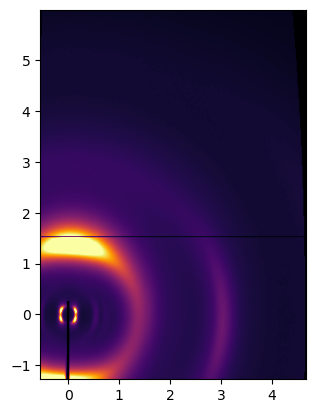

In [76]:
smi.stitching_data(interp_factor=1)

fig, ax = plt.subplots()
plot_2d_image(smi.img_st, ax, extent=[*smi.qp, *smi.qz])
plt.show()

## Caking Procedure

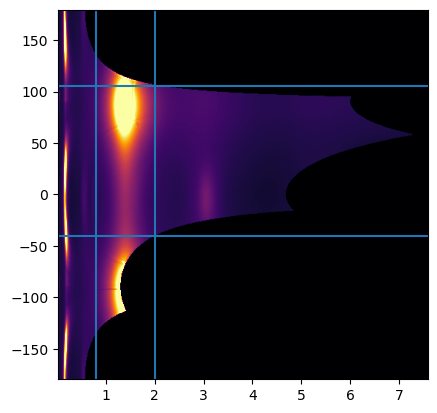

In [77]:
smi.caking()
fig, ax = plt.subplots()
aspect = abs(smi.q_cake[0]-smi.q_cake[-1]) / abs(smi.chi_cake[0] - smi.chi_cake[-1])
extent = [smi.q_cake[0], smi.q_cake[-1], smi.chi_cake[-1], smi.chi_cake[0]]
plot_2d_image(smi.cake, ax=ax, extent=extent, aspect=aspect)

ax.axvline(.8)
ax.axvline(2)
ax.axhline(105)
ax.axhline(-40)
plt.show()

## Radial Integration

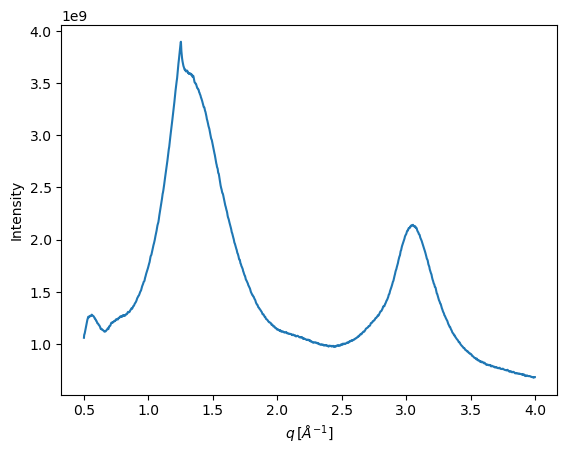

In [78]:
smi.radial_averaging(radial_range=(0.5,4))

plt.plot(smi.q_rad, smi.I_rad)
plt.xlabel('$q \, [\AA^{-1}]$')
plt.ylabel('Intensity')
plt.show()

## Azimuthal Integration

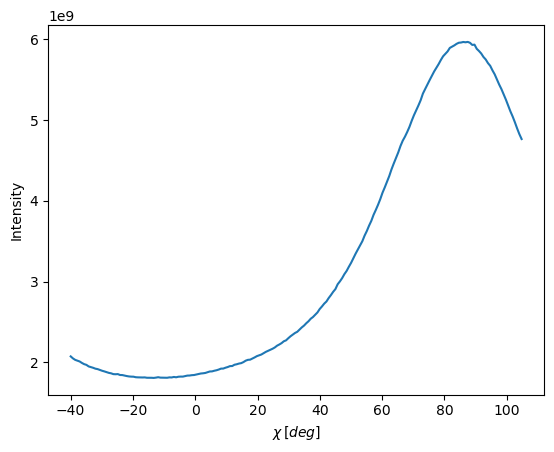

In [79]:
smi.azimuthal_averaging(radial_range=(0.8, 2.0), azimuth_range=(-40, 105))

plt.plot(smi.chi_azi, smi.I_azi)
plt.xlabel('$\chi \, [deg]$')
plt.ylabel('Intensity')
plt.show()